# Machine Learning from Sensor and Anthropometric to predict Force Plate Data

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import joblib as joblib
from scipy import stats
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RANSACRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.ticker import AutoMinorLocator
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import tensorflow.keras as keras
from tensorflow.saved_model import save
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

plt.style.use(['default'])

test_size = 0.2

Nruns = 5

verbose = 0

shuffle = False

if shuffle:
  random_state = 0
else:
  random_state = None

output = pd.DataFrame()

seed = 0

tf.random.set_seed(0)

#### Read the data

In [2]:
df = pd.read_csv("./data.csv", index_col = 0)
df

,DF,DF_acc,Fmax,Fmax_acc,SF,gender,height,id,mass,speed,stride_frequency_acc,tc,tc_acc,tce,tce_acc,tf,tf_acc,tfe,tfe_acc
0,39.486609,36.128567,2.206896,2.386766,1.320652,1.0,1.814,1.0,71.0,9.0,1.321736,299.00,273.355210,185.50,184.100120,79.50,104.831485,193.25,194.564290
1,34.614273,34.777315,2.443751,2.551213,1.325026,1.0,1.814,1.0,71.0,11.0,1.326868,261.25,262.112920,173.75,183.526530,116.25,114.451515,203.75,192.997505
2,32.026390,34.381069,2.557735,2.590335,1.344306,1.0,1.814,1.0,71.0,13.0,1.344604,238.25,255.725865,163.25,180.693115,133.75,116.127615,208.75,191.162855
3,35.330573,35.865979,2.526297,2.579239,1.241944,1.0,1.845,2.0,73.0,9.0,1.243967,284.50,288.336215,180.50,187.636545,117.75,113.438255,221.75,214.801370
4,34.172583,36.186117,2.541977,2.437700,1.292138,1.0,1.845,2.0,73.0,11.0,1.284106,264.50,281.794470,174.25,191.094240,122.50,107.661510,212.75,198.664495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,38.336334,34.129458,2.286319,2.298037,1.522776,1.0,1.825,115.0,86.0,11.0,1.524588,251.75,223.890160,154.25,150.635725,76.50,103.930035,174.00,177.338905
296,37.263357,35.047001,2.307996,2.420906,1.520772,1.0,1.825,115.0,86.0,13.0,1.520069,245.00,230.611655,156.00,157.395665,84.00,97.922215,173.25,171.185075
297,33.626847,33.868893,2.569908,2.539892,1.349239,0.0,1.730,116.0,68.0,9.0,1.349597,249.25,250.989915,157.75,177.876190,121.25,119.221030,212.75,192.297620
298,33.069507,33.690017,2.590511,2.590751,1.441001,0.0,1.730,116.0,68.0,11.0,1.439266,229.50,234.095610,146.50,167.368760,117.75,113.221300,200.50,179.907965


#### Create a function that plot predicted vs ground truth data

In [3]:
def plot_pred_vs_ground_truth(y, y_pred):
  fig, axes = plt.subplots(1, 2, figsize = (14, 5))

  axes[0].plot(np.arange(np.min(y), np.max(y), 0.5), np.arange(np.min(y), np.max(y), 0.5), '--', c = 'k', lw = 0.8)
  axes[1].plot(0 * np.arange(np.min(y), np.max(y), 0.5), np.arange(np.min(y), np.max(y), 0.5), '--', c = 'k', lw = 0.8)
  
  axes[0].scatter(y_pred, y, s = 50, color = 'k')
  axes[1].scatter(y_pred - y, y, s = 50, color = 'k')                           

  axes[0].set_ylabel('Ground truth val')
  axes[1].set_ylabel('Ground truth val')

  axes[0].set_xlabel('Predicted val')
  axes[1].set_xlabel('Predicted - Ground truth (∆)')
  
  R2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
  r = np.sqrt(R2)
  RMSE = np.sqrt(np.sum( (y - y_pred)**2) / len(y))
  MAPE = 100 / len(y) * np.sum( np.abs((y - y_pred) / y))
  axes[0].text(1, 1.025, "MAPE = %.3f\tRMSE = %.3f\t$r = $ %.3f\t$R^2 = $ %.3f" % (MAPE, RMSE, r, R2), transform = axes[0].transAxes, ha = 'right', fontsize = 14)

  fig.tight_layout()
  plt.show()

#### Create a function that plot loss and accuracy

In [4]:
def plot_loss_acc(history):
  plt.style.use(['default'])
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

  # Plot accuracy values
  ax1.plot(history.history['loss'], label='train loss')
  ax1.plot(history.history['val_loss'], label='val loss')
  ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(np.mean(history.history['val_loss'][-3:])), fontsize = 12)
  ax1.set_xlabel('epoch', fontsize = 12)
  ax1.set_ylabel('loss value', fontsize = 12)
  ax1.legend(fontsize = 12)

  # Plot accuracy values
  ax2.plot(history.history['root_mean_squared_error'], label='train rmse')
  ax2.plot(history.history['val_root_mean_squared_error'], label='val rmse')
  ax2.set_title('Validation mape {:.3f} (mean last 3)'.format(np.mean(history.history['val_root_mean_squared_error'][-3:])), fontsize = 12)
  ax2.set_xlabel('epoch', fontsize = 12)
  ax2.set_ylabel('root mean squared error', fontsize = 12)
  ax2.legend(fontsize = 12)
  plt.show()

#### Create a function returning a key from a value of a dictionary

In [5]:
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

## Train-test split

In [6]:
random.seed(seed)
ids = list(df.id.unique())
ids_test = random.sample(ids, int(test_size * len(ids)))
df_train = df[~df.id.isin(ids_test)]
df_test = df[df.id.isin(ids_test)]

In [7]:
var = "tf"
features = ["mass", "stride_frequency_acc", "speed", var + "_acc"]

In [8]:
y       = df[var].values
y_train = df_train[var].values
y_test  = df_test[var].values

#### stratify train-test split

In [9]:
if shuffle:
  stratify = y
  
  X = df[features].values
  X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_size, stratify = stratify, random_state = random_state, shuffle = shuffle)
else:
  stratify = None
  
  # basic features
  X_tr = df_train[features].values
  X_te = df_test[features].values
  y_tr = y_train
  y_te = y_test

## Model using no features

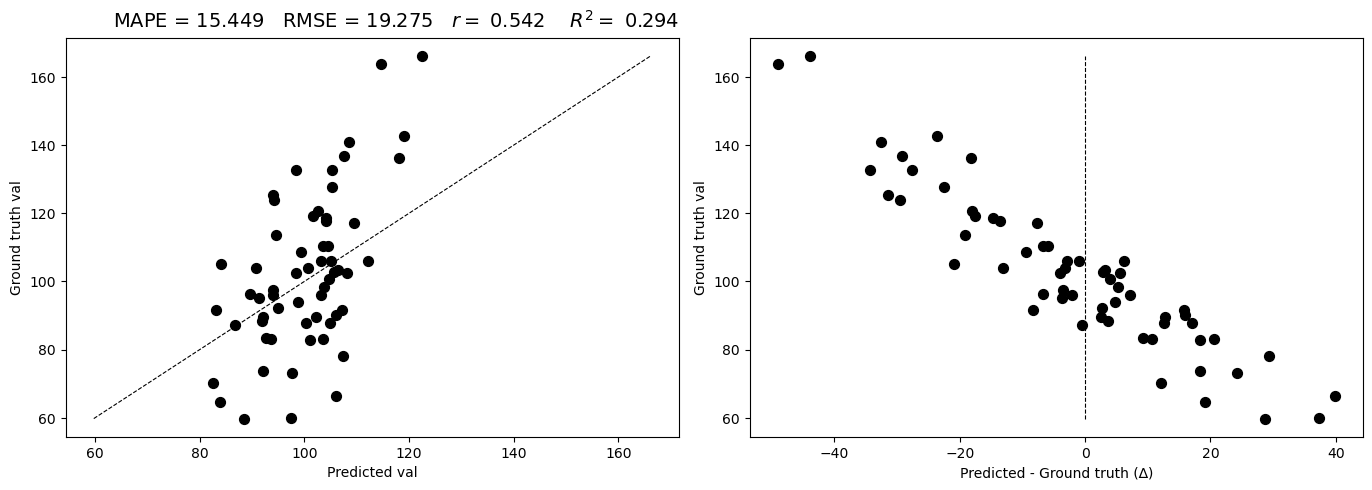

MAPE:  15.448706530980044  ±  13.193555161103822 %


In [10]:
plot_pred_vs_ground_truth(y_te, df_test[features[-1]].values)
y_te_pred_no_model = df_test[features[-1]].values
print("MAPE: ", np.mean(100 * np.abs((y_te - y_te_pred_no_model))/y_te), " ± ", np.std(100 * np.abs((y_te - y_te_pred_no_model))/y_te), "%")

## Model using linear regression

#### Create a grid to vary fit_intercept in the linear regression, instantiate a pipeline, and create a KFold object

In [11]:
# Define the keys
linreg_fit_intercept = 'linReg__fit_intercept'

# Define the values
fit_intercepts = [True, False]

# Define a grid of values
grid_dict = { 
  linreg_fit_intercept: fit_intercepts
}

grid = ParameterGrid(grid_dict)

# create a KFold object
kfold = KFold(n_splits = Nruns, random_state = random_state, shuffle = shuffle)

#### Create a function to perform cross validation and save scores

In [12]:
def get_scores(grid, X_tr, y_tr):
  # Create a pipeline
  pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linReg', LinearRegression(n_jobs = -1))
  ])
  
  scores = []
  
  for params_dict in grid:
    train_accuracy, valid_accuracy = [], []

    for train_index, val_index in kfold.split(X_tr, y_tr):
      
      X_train, X_valid = X_tr[train_index], X_tr[val_index]
      y_train, y_valid = y_tr[train_index], y_tr[val_index]

      pipe.set_params(**params_dict)
      pipe.fit(X_train, y_train)

      train_accuracy.append(pipe.score(X_train, y_train))
      valid_accuracy.append(pipe.score(X_valid, y_valid))
    
    mean_train_acc = np.mean(np.array(train_accuracy))
    std_train_acc  = np.std(np.array(train_accuracy))
  
    mean_valid_acc = np.mean(np.array(valid_accuracy))
    std_valid_acc  = np.std(np.array(valid_accuracy))
  
    params_dict["mean_train_accuracy"] = mean_train_acc
    params_dict["std_train_accuracy"]  = std_train_acc
  
    params_dict["mean_valid_accuracy"] = mean_valid_acc
    params_dict["std_valid_accuracy"]  = std_valid_acc
  
    scores.append(params_dict)

  # sort scores according to the mean validation accuracy
  scores = pd.DataFrame(scores)
  sorted_scores = scores.sort_values(by = 'mean_valid_accuracy', ascending = False)
  
  return pipe, scores, sorted_scores

#### Create a function that get the best score and append it to the dataframe containing all scores

In [13]:
def get_best_params(pipe, X_tr, X_te, y_tr, y_te, sorted_scores, name, output):
  best_params = {linreg_fit_intercept:sorted_scores.iloc[0][linreg_fit_intercept]}

  pipe.set_params(**best_params)
  pipe.fit(X_tr, y_tr)
  
  y_tr_pred = pipe.predict(X_tr)
  y_te_pred = pipe.predict(X_te)
 
  data = {}
  data["model-name"]         = "lin-reg__" + name
  data["model-fit"]          = pipe
  data[linreg_fit_intercept] = best_params[linreg_fit_intercept]
  data["train_score"]        = pipe.score(X_tr, y_tr)
  data["test_score"]         = pipe.score(X_te, y_te)
  
  output = output.append(data, ignore_index = True)
  return y_tr_pred, y_te_pred, output

In [14]:
pipe, scores, sorted_scores = get_scores(grid, X_tr, y_tr)

In [15]:
y_tr_pred, y_te_pred, output = get_best_params(pipe, X_tr, X_te, y_tr, y_te, sorted_scores, "features", output)

In [16]:
output.iloc[[-1]]
output.iloc[[-1]]["model-fit"].values[0].named_steps['linReg'].coef_

array([-5.32551413, -3.34892779, 13.79690422, 12.50446579])

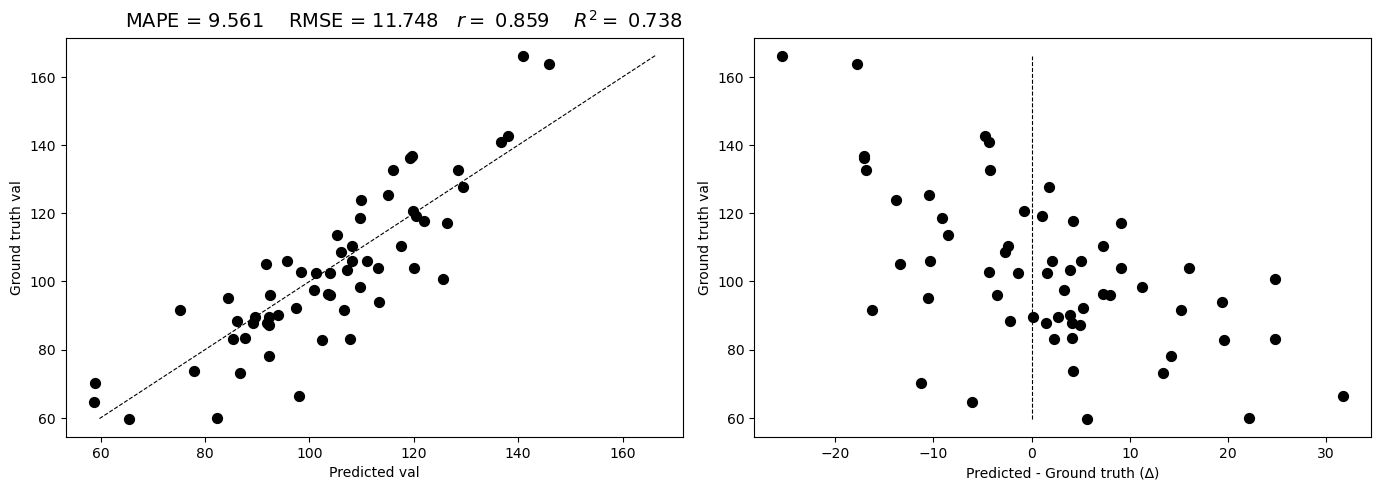

In [17]:
plot_pred_vs_ground_truth(y_te, y_te_pred)

In [18]:
y_te_pred_lm = y_te_pred

In [19]:
coefs = np.append(output.iloc[[-1]]["model-fit"].values[0].named_steps['linReg'].intercept_, output.iloc[[-1]]["model-fit"].values[0].named_steps['linReg'].coef_)
X_tr_new = pd.DataFrame({"Constant":np.ones(len(X_tr))}).join(pd.DataFrame(X_tr))
mse = np.sum((y_tr - y_tr_pred)**2, axis = 0) / (X_tr_new.shape[0] - X_tr_new.shape[1])
variance = mse * (np.linalg.inv(np.dot(X_tr_new.T, X_tr_new)).diagonal())
se = np.sqrt(variance)
ts = coefs / se
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (X_tr_new.shape[0] - X_tr_new.shape[1]))) for i in ts]
df_p_values = pd.DataFrame(np.array([np.round(coefs, 4), np.round(se, 3), np.round(ts, 3), np.round(p_values, 4)]).T, columns = ["coefficients", "standard-errors", "t-values", "p-values"], index = ["intercept", *features])
print(df_p_values)

                      coefficients  standard-errors  t-values  p-values
intercept                 110.6448           28.237     3.918    0.0001
mass                       -5.3255            0.108   -49.270    0.0000
stride_frequency_acc       -3.3489           15.795    -0.212    0.8323
speed                      13.7969            0.606    22.785    0.0000
tf_acc                     12.5045            0.103   121.969    0.0000


## Model using svm rbf

#### Create a grid to vary the regularization strength, instantiate a pipeline, and create a KFold object

In [20]:
# Define the keys
svm_C     = 'svm__C'
svm_epsilon = 'svm__epsilon'

# Define the values
C_values     = np.logspace(-3, 4, num = 20)
epsilon_values = np.logspace(-3, 2, num = 20)

# Define a grid of values
grid_dict = { 
  svm_C: C_values,  
  svm_epsilon: epsilon_values
}

grid = ParameterGrid(grid_dict)

# create a KFold object
kfold = KFold(n_splits = Nruns, random_state = random_state, shuffle = shuffle)

#### Create a function to perform cross validation and save scores

In [21]:
def get_scores(grid, X_tr, y_tr):
  # Create a pipeline
  pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR(kernel = 'rbf'))
  ])

  scores = []
  
  for params_dict in grid:
 
    train_accuracy, valid_accuracy = [], []

    for train_index, val_index in kfold.split(X_tr, y_tr):
      
      X_train, X_valid = X_tr[train_index], X_tr[val_index]
      y_train, y_valid = y_tr[train_index], y_tr[val_index]

      pipe.set_params(**params_dict)
      pipe.fit(X_train, y_train)

      train_accuracy.append(pipe.score(X_train, y_train))
      valid_accuracy.append(pipe.score(X_valid, y_valid))
    
    mean_train_acc = np.mean(np.array(train_accuracy))
    std_train_acc  = np.std(np.array(train_accuracy))
  
    mean_valid_acc = np.mean(np.array(valid_accuracy))
    std_valid_acc  = np.std(np.array(valid_accuracy))
  
    params_dict["mean_train_accuracy"] = mean_train_acc
    params_dict["std_train_accuracy"]  = std_train_acc
  
    params_dict["mean_valid_accuracy"] = mean_valid_acc
    params_dict["std_valid_accuracy"]  = std_valid_acc
  
    scores.append(params_dict)

  # sort scores according to the mean validation accuracy
  scores = pd.DataFrame(scores)
  sorted_scores = scores.sort_values(by = 'mean_valid_accuracy', ascending = False)
  
  return pipe, scores, sorted_scores

#### Create a function that get the best score and append it to the dataframe containing all scores

In [22]:
def get_best_params(pipe, X_tr, X_te, y_tr, y_te, sorted_scores, name, output):

  best_params = {svm_epsilon:sorted_scores.iloc[0][svm_epsilon], svm_C: sorted_scores.iloc[0][svm_C]}

  pipe.set_params(**best_params)
  pipe.fit(X_tr, y_tr)

  y_tr_pred = pipe.predict(X_tr)
  y_te_pred = pipe.predict(X_te)
  
  data = {}
  data["model-name"]         = "svm-rbf__" + name
  data["model-fit"]          = pipe
  data[svm_epsilon]          = best_params[svm_epsilon]
  data[svm_C]                = best_params[svm_C]
  data["train_score"]        = pipe.score(X_tr, y_tr)
  data["test_score"]         = pipe.score(X_te, y_te)
  
  output = output.append(data, ignore_index = True)
  return y_tr_pred, y_te_pred, output

In [23]:
pipe, scores, sorted_scores = get_scores(grid, X_tr, y_tr)

In [24]:
y_tr_pred, y_te_pred, output = get_best_params(pipe, X_tr, X_te, y_tr, y_te, sorted_scores, "features", output)

In [25]:
output.iloc[[-1]]

,linReg__fit_intercept,model-fit,model-name,test_score,train_score,svm__C,svm__epsilon
1,NaN,"(StandardScaler(), SVR(C=11.288378916846883, e...",svm-rbf__features,0.757283,0.710373,11.288379,0.233572


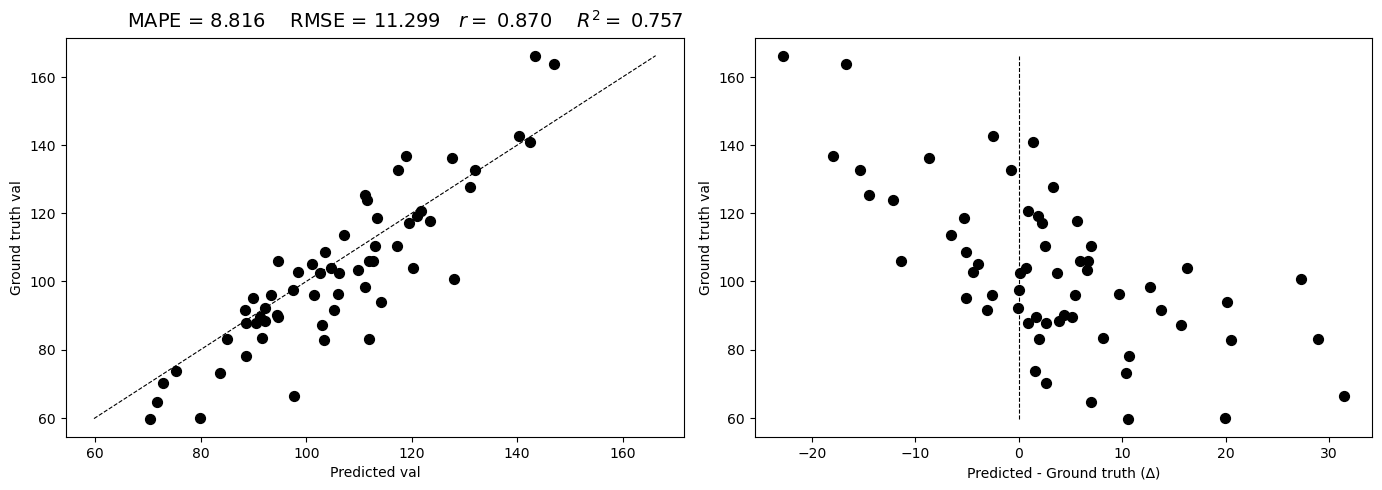

In [26]:
plot_pred_vs_ground_truth(y_te, y_te_pred)

In [27]:
y_te_pred_svm_rbf = y_te_pred

## Model using 2 layers neural network

In [28]:
def create_model(activation_in = "relu", inner_dim = 64, activation_out = "sigmoid", optimizer = "adam", loss = "mean_squared_error", input_dim = 23, output_dim = 1):
  model = Sequential()
  model.add(Dense(inner_dim, activation = activation_in, input_dim = input_dim))
  model.add(Dense(output_dim, input_dim = inner_dim))
  model.compile(optimizer = optimizer, loss = loss, metrics = ['RootMeanSquaredError'])
  return model

#### Create a grid to vary the neural network parameters and create a KFold object

In [29]:
# Define the keys
nn_activation_in  = 'nn__activation_in'
nn_inner_dim      = 'nn__inner_dim'
nn_activation_out = 'nn__activation_out'
nn_optimizer      = 'nn__optimizer'
nn_loss           = 'nn__loss'
nn_batch_size     = 'nn__batch_size'
nn_epochs         = 'nn__epochs'

# Define the values
activations_in  = ["relu", "tanh", "sigmoid", "softmax"]
inner_dims      = [8, 16, 32, 64]
activations_out = ["-----"]
optimizers      = ["adam"]
losses          = ["mean_absolute_error", "mean_squared_error"]
batch_sizes     = [2, 4, 8, 16]
epochs          = [1000]

# Define a grid of values
nn_grid_dict = { 
  nn_activation_in:  activations_in,
  nn_inner_dim:      inner_dims,
  nn_activation_out: activations_out,
  nn_optimizer:      optimizers,
  nn_loss:           losses,
  nn_batch_size:     batch_sizes,
  nn_epochs:         epochs
}

nn_grid = ParameterGrid(nn_grid_dict)

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, min_delta = 0.05, restore_best_weights = True, verbose = 2)

# create a KFold object
kfold = KFold(n_splits = Nruns, random_state = random_state, shuffle = shuffle)

#### Create a function to perform cross validation and save scores

In [30]:
def get_scores(grid, X_tr, y_tr, shuffle = False, callbacks = None, verbose = 0):
  tf.random.set_seed(0)
  
  scores = []
  
  for params_dict in grid:
    print(params_dict)
    
    train_accuracy, valid_accuracy = [], []

    for train_index, valid_index in kfold.split(X_tr, y_tr):
      
      X_train, X_valid = X_tr[train_index], X_tr[valid_index]
      y_train, y_valid = y_tr[train_index], y_tr[valid_index]

      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_valid = scaler.transform(X_valid)
  
      model = create_model(activation_in = params_dict[nn_activation_in], inner_dim = params_dict[nn_inner_dim], activation_out = params_dict[nn_activation_out],  
                           optimizer = params_dict[nn_optimizer], loss = params_dict[nn_loss], input_dim = X_train.shape[1], output_dim = 1)
          
      history = model.fit(X_train, y_train, batch_size = params_dict[nn_batch_size], epochs = params_dict[nn_epochs], shuffle = shuffle, verbose = verbose, callbacks = callbacks, validation_data = (X_valid, y_valid), validation_freq = 1)
           
      train_R2 = 1 - np.sum((y_train - model.predict(X_train).flatten())**2) / np.sum((y_train - np.mean(y_train))**2)   
      valid_R2 = 1 - np.sum((y_valid - model.predict(X_valid).flatten())**2) / np.sum((y_valid - np.mean(y_valid))**2)
      
      train_accuracy.append(train_R2)
      valid_accuracy.append(valid_R2)
    
    mean_train_acc = np.mean(np.array(train_accuracy))
    std_train_acc  = np.std(np.array(train_accuracy))
  
    mean_valid_acc = np.mean(np.array(valid_accuracy))
    std_valid_acc  = np.std(np.array(valid_accuracy))
  
    params_dict["mean_train_accuracy"] = mean_train_acc
    params_dict["std_train_accuracy"]  = std_train_acc
  
    params_dict["mean_valid_accuracy"] = mean_valid_acc
    params_dict["std_valid_accuracy"]  = std_valid_acc
  
    scores.append(params_dict)

  # sort scores according to the mean validation accuracy
  scores = pd.DataFrame(scores)
  sorted_scores = scores.sort_values(by = 'mean_valid_accuracy', ascending = False)
  
  return scores, sorted_scores

#### Create a function that get the best score and append it to the dataframe containing all scores

In [31]:
def get_best_params(X_tr, X_te, y_tr, y_te, sorted_scores, name, output, shuffle = False, callbacks = None, verbose = 0):
  tf.random.set_seed(0)
  
  best_params = {nn_activation_in:sorted_scores.iloc[0][nn_activation_in], nn_inner_dim:sorted_scores.iloc[0][nn_inner_dim],
                 nn_activation_out:sorted_scores.iloc[0][nn_activation_out],  nn_optimizer: sorted_scores.iloc[0][nn_optimizer], nn_loss: sorted_scores.iloc[0][nn_loss],  
                 nn_batch_size: sorted_scores.iloc[0][nn_batch_size], nn_epochs: sorted_scores.iloc[0][nn_epochs]}
 
  scaler = StandardScaler()
  X_tr = scaler.fit_transform(X_tr)
  X_te = scaler.transform(X_te)
  
  model = create_model(activation_in = best_params[nn_activation_in], inner_dim = best_params[nn_inner_dim], activation_out = best_params[nn_activation_out],  
                           optimizer = best_params[nn_optimizer], loss = best_params[nn_loss], input_dim = X_tr.shape[1], output_dim = 1)
  
  history = model.fit(X_tr, y_tr, batch_size = best_params[nn_batch_size], epochs = best_params[nn_epochs], shuffle = shuffle, verbose = verbose, callbacks = callbacks, validation_data = (X_te, y_te), validation_freq = 1)
 
  y_tr_pred = model.predict(X_tr).flatten()
  y_te_pred = model.predict(X_te).flatten()

  data = {}
  data["model-name"]         = "neural-net-two-layers__" + name
  data["scaler-fit"]         = scaler
  data["model-fit"]          = model
  data[nn_activation_in]     = best_params[nn_activation_in]
  data[nn_inner_dim]         = best_params[nn_inner_dim]
  data[nn_activation_out]    = best_params[nn_activation_out]
  data[nn_optimizer]         = best_params[nn_optimizer]
  data[nn_loss]              = best_params[nn_loss]
  data[nn_batch_size]        = best_params[nn_batch_size]
  data[nn_epochs]            = best_params[nn_epochs]
  data["train_score"]        = 1 - np.sum((y_tr - y_tr_pred)**2) / np.sum((y_tr - np.mean(y_tr))**2)
  data["test_score"]         = 1 - np.sum((y_te - y_te_pred)**2) / np.sum((y_te - np.mean(y_te))**2)
  data["history"]            = history
  
  output = output.append(data, ignore_index = True)
  return history, y_tr_pred, y_te_pred, output

In [32]:
scores, sorted_scores = get_scores(nn_grid, X_tr, y_tr, shuffle = shuffle, callbacks = [early_stopping], verbose = verbose)

{'nn__activation_in': 'relu', 'nn__activation_out': '-----', 'nn__batch_size': 2, 'nn__epochs': 1000, 'nn__inner_dim': 8, 'nn__loss': 'mean_absolute_error', 'nn__optimizer': 'adam'}
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00181: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00150: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
{'nn__activation_in': 'relu', 'nn__activation_out': '-----', 'nn__batch_size': 2, 'nn__epochs': 1000, 'nn__inner_dim': 8, 'nn__loss': 'mean_squared_error', 'nn__optimizer': 'adam'}
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Restoring model weights from the end of the best 

In [33]:
history, y_tr_pred, y_te_pred, output = get_best_params(X_tr, X_te, y_tr, y_te, sorted_scores, "features", output, shuffle = shuffle, callbacks = [early_stopping], verbose = verbose)

Restoring model weights from the end of the best epoch.
Epoch 00483: early stopping


In [34]:
output.iloc[[-1]]

,linReg__fit_intercept,model-fit,model-name,test_score,train_score,svm__C,svm__epsilon,history,nn__activation_in,nn__activation_out,nn__batch_size,nn__epochs,nn__inner_dim,nn__loss,nn__optimizer,scaler-fit
2,NaN,<tensorflow.python.keras.engine.sequential.Seq...,neural-net-two-layers__features,0.721834,0.730756,NaN,NaN,<tensorflow.python.keras.callbacks.History obj...,sigmoid,-----,2.0,1000.0,64.0,mean_squared_error,adam,StandardScaler()


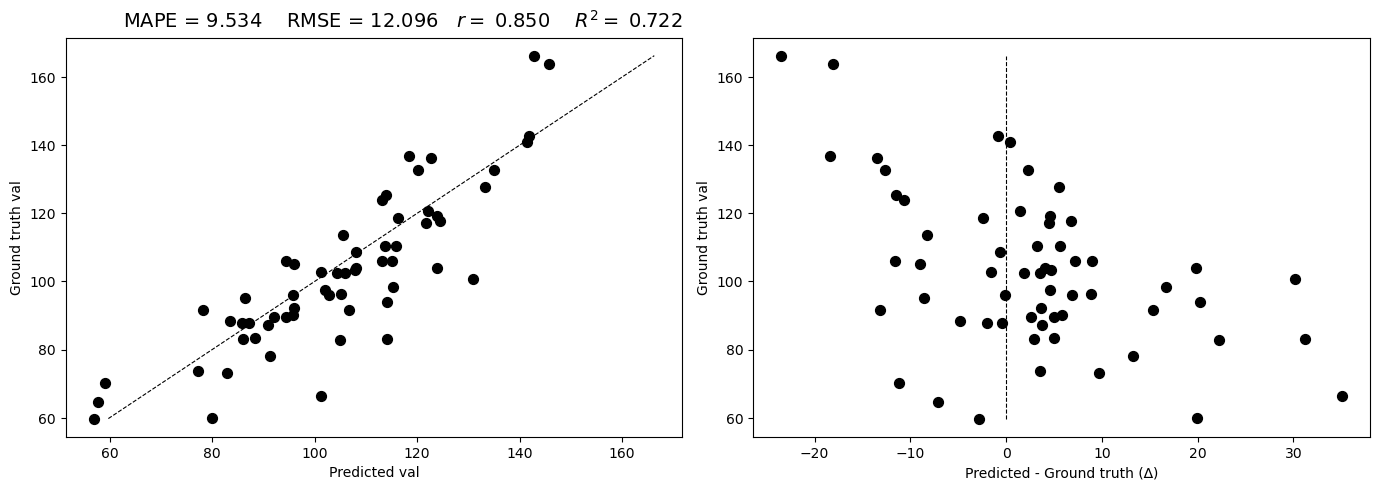

In [35]:
plot_pred_vs_ground_truth(y_te, y_te_pred)

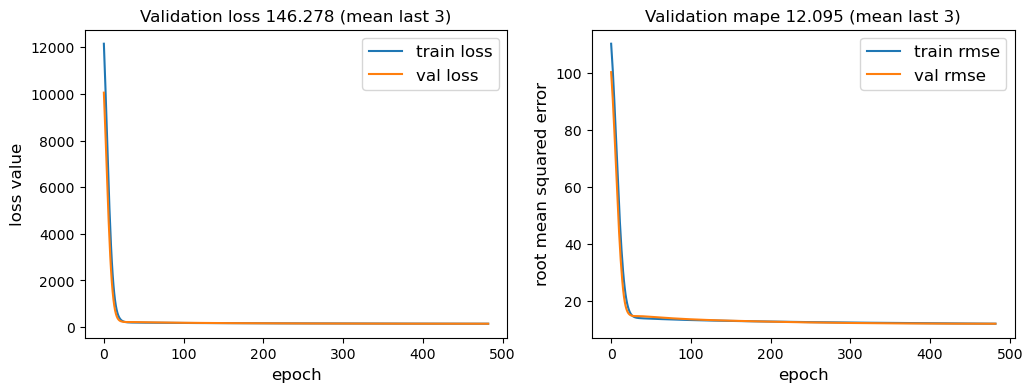

In [36]:
plot_loss_acc(history)

In [37]:
y_te_pred_nn2 = y_te_pred